# UK Winter Temperature prediction


The aim of this project is to collect open data on climate indices and weather to predict whether the UK will have a colder than average winter this year. This is especially relevant for the winter of 2022/2023 with the war in Ukraine causing massive Gas and Oil problems for the UK and Europe as a whole.

So, the question we are asking is: <br /> <br />

### Can we use the Climate Indices data from the Autumn months to predict/estimate the mean upcoming winter temperature?
<br />

Data Sources listed below:


AO - https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii <br />
The Arctic Oscillation (AO) measures the back-and-forth shifting of atmospheric pressure between the Arctic and the mid-latitudes of the North Pacific and North Atlantic. When the AO is strongly positive, a strong mid-latitude jet stream steers storms northward, reducing cold air outbreaks in the mid-latitudes. When the AO is strongly negative, a weaker, meandering jet dips farther south, allowing Arctic  air to spill into the mid-latitudes. (source: https://www.climate.gov/news-features/understanding-climate/climate-variability-arctic-oscillation) <br /><br />

NAO - https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii <br />
The NAO (North Atlantic Oscillation) is a weather phenomenon over the North Atlantic Ocean of fluctuations in the difference of atmospheric pressure at sea level (SLP) between the Icelandic Low and the Azores High. (source: https://en.wikipedia.org/wiki/North_Atlantic_oscillation 
<br /><br />

PNA - https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii <br />
The Pacific/North American teleconnection pattern (PNA) is one of the most recognized, influential climate patterns in the Northern Hemisphere mid-latitudes beyond the tropics. It consists of anomalies in the geopotential height fields (typically at 700 or 500mb) observed over the western and eastern United States. It is important to note that the PNA has been found to be strongly influenced by the El Niño-Southern Oscillation (ENSO) phenomenon. The positive phase of the PNA pattern tends to be associated with Pacific warm episodes (El Niño), and the negative phase tends to be associated with Pacific cold episodes (La Niña). (source: https://legacy.climate.ncsu.edu/climate/patterns/pna)
<br /><br />

nino3.4 - https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt <br />
El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). 
(source: https://www.ncei.noaa.gov/access/monitoring/enso/sst)
<br /><br />

PDO - https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat <br />
The Pacific Decadal Oscillation (PDO) is often described as a long-lived El Niño-like pattern of Pacific climate variability (Zhang et al. 1997). As seen with the better-known El Niño/Southern Oscillation (ENSO), extremes in the PDO pattern are marked by widespread variations in the Pacific Basin and the North American climate.(source: https://www.ncei.noaa.gov/access/monitoring/pdo/)
<br /><br />

SOI - https://crudata.uea.ac.uk/cru/data/soi/soi.dat <br />
The Southern Oscillation Index (SOI) is a standardized index based on the observed sea level pressure (SLP) differences between Tahiti and Darwin, Australia. The SOI is one measure of the large-scale fluctuations in air pressure occurring between the western and eastern tropical Pacific (i.e., the state of the Southern Oscillation) during El Niño and La Niña episodes.
(source: https://www.ncei.noaa.gov/access/monitoring/enso/soi)
<br /><br />

QBO - https://www.cpc.ncep.noaa.gov/data/indices/qbo.u50.index <br />
The Quasi-Biennial Oscillation is a regular variation of the winds that blow high above the equator. Strong winds in the stratosphere travel in a belt around the planet, and every 14 months or so, these winds completely change direction. 
(source: https://www.metoffice.gov.uk/weather/learn-about/weather/atmosphere/quasi-biennial-oscillation)
<br /><br />

Sunspots - https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json <br />
(source: https://en.wikipedia.org/wiki/Solar_activity_and_climate)
<br /><br />

AMO - https://psl.noaa.gov/data/correlation/amon.us.data <br />
The Atlantic Multi-decadal Oscillation (AMO) has been identified as a coherent mode of natural variability occurring in the North Atlantic Ocean with an estimated period of 60-80 years. It is based upon the average anomalies of sea surface temperatures (SST) in the North Atlantic basin, typically over 0-80N.
(source: https://climatedataguide.ucar.edu/climate-data/atlantic-multi-decadal-oscillation-amo)
<br /><br />

Siberian Snow Cover - http://climate.rutgers.edu/snowcover/files/moncov.eurasia.txt # sq. km <br />
(source: https://www.nohrsc.noaa.gov/nh_snowcover/)
<br /><br />

UK temperature - https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Rainfall/date/England.txt <br />
<br />

UK rainfall - https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmean/date/England.txt <br />
<br />
***

First, let's gather all of the data listed above:

In [1]:
import pandas as pd
import re
from io import StringIO
import numpy as np
import requests
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats

def month_cols_to_rows(df, output_value_col_name):
    """
    Formats a string containing time series data to a pandas DataFrame

    This function simply wraps the ``+`` operator, and does not
    do anything interesting, except for illustrating what
    the docstring of a very simple function looks like.

    Parameters
    ----------
    num1 : int
        First number to add.
    num2 : int
        Second number to add.

    Returns
    -------
    int
        The sum of ``num1`` and ``num2``.
    """
    
    if len(df.columns) != 12:
        print('Are you sure there are 12 months (plus the year as index) present in this DataFrame?')
        return
    new_df = []
    for y in df.index:
        month_start = 0
        for row in df[df.index == y].values:
            for r in row:
                month_start = month_start++1
                new_df.append([y,month_start,r])

    new_df=pd.DataFrame(new_df)
    new_df.columns = ['Year', 'Month', output_value_col_name]
    #new_df = new_df.set_index('Year')
    
    return new_df

def format_type_1(s):
    """
    Formats a string containing time series data to a pandas DataFrame

    This function simply wraps the ``+`` operator, and does not
    do anything interesting, except for illustrating what
    the docstring of a very simple function looks like.

    Parameters
    ----------
    num1 : int
        First number to add.
    num2 : int
        Second number to add.

    Returns
    -------
    int
        The sum of ``num1`` and ``num2``.
    """
    
    s = StringIO(re.sub(' +', ',', s))

    d = pd.read_csv(s)

    # When reading a string as a CSV, pandas automatically assigns the first row as the header, 
    # we want to move that header back to the rows and recreate an appropriate header
    d.loc[len(d)] = list(d.columns)
    d.columns = np.arange(0,len(d.columns),1)
    return d



In [2]:
############################
r = requests.get('http://climate.rutgers.edu/snowcover/files/moncov.eurasia.txt')
eurasian_snow_cover_data = format_type_1(r.text)
eurasian_snow_cover_data.columns = ['Year', 'Month', 'Eurasian_Snow_Cover']
eurasian_snow_cover_data = eurasian_snow_cover_data.apply(pd.to_numeric, errors='coerce')
eurasian_snow_cover_data['Eurasian_Snow_Cover'] = eurasian_snow_cover_data['Eurasian_Snow_Cover']/10e6 # Sq Km to Mil Sq km
#####################

In [3]:
############################
# r = requests.get("https://www.metoffice.gov.uk/hadobs/hadcet/data/meantemp_daily_totals.txt")
# s = StringIO(re.sub(' +', ',', r.text)) #replace all spaces (and consecutive spaces) with commas
# CET = pd.read_csv(s)
# CET = CET.set_index('Date')
# CET['Year and Month'] = CET.index.str[:-3]
# CE_Monthly = CET.groupby('Year and Month').mean()
# CE_Monthly = CE_Monthly.reset_index()

# CE_Monthly[['Year', 'Month']] = CE_Monthly['Year and Month'].str.split('-', expand=True)
# CE_Monthly = CE_Monthly.drop(columns = 'Year and Month')
# CE_Monthly = CE_Monthly.rename(columns={'Value':'CET Mean'})
############################

In [4]:
############################
r = requests.get("https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt")
s = StringIO(re.sub(' +', ',', r.text[1:])) #replace all spaces (and consecutive spaces) with commas
Nino = pd.read_csv(s)
Nino = Nino[['YR','MON','TOTAL']]
Nino = Nino.rename(columns = {'YR':'Year','MON':'Month','TOTAL':'Nino3.4'})
Nino = Nino.apply(pd.to_numeric, errors='coerce')
############################

In [5]:
############################
r = requests.get("https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat")
s = StringIO(re.sub(' +', ',', r.text[18:])) #replace all spaces (and consecutive spaces) with commas
PDO = pd.read_csv(s)
PDO = PDO.set_index('Year')
PDO = month_cols_to_rows(PDO, 'PDO')
PDO = PDO.apply(pd.to_numeric, errors='coerce')
############################



In [6]:
############################
r = requests.get("https://www.cpc.ncep.noaa.gov/data/indices/soi")
s = StringIO(re.sub(' +', ',', r.text[242:-6485].replace('-999.9',' '))) #replace all spaces (and consecutive spaces) with commas

SOI = pd.read_csv(s)
SOI = SOI.set_index('YEAR')
SOI = SOI.drop(columns = ['Unnamed: 13'])
SOI = month_cols_to_rows(SOI, 'SOI')
SOI = SOI.apply(pd.to_numeric, errors='coerce')
############################

In [7]:
############################
sunspots = pd.read_json("https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json")
sunspots = sunspots[['time-tag','ssn']]
sunspots[['Year', 'Month']]=sunspots['time-tag'].str.split('-', expand=True)
sunspots = sunspots.drop(columns = ['time-tag'])
sunspots = sunspots.rename(columns={'ssn': 'Sunspots'})
sunspots = sunspots.apply(pd.to_numeric, errors='coerce')

In [8]:
r = requests.get("https://www.cpc.ncep.noaa.gov/data/indices/qbo.u50.index")
s = StringIO(re.sub(' +', ',', r.text[243:4765].replace('-999.9',' ')))
QBO = pd.read_csv(s)
QBO = QBO.drop(columns = ['Unnamed: 13'])
QBO = QBO.set_index('YEAR')
QBO = month_cols_to_rows(QBO, 'QBO')
QBO = QBO.apply(pd.to_numeric, errors='coerce')


In [9]:
#####################
r = requests.get("https://psl.noaa.gov/data/correlation/amon.us.data")
AMO = format_type_1(r.text[21:-135])
AMO = AMO.set_index(0)
AMO = month_cols_to_rows(AMO, 'AMO')
AMO = AMO.apply(pd.to_numeric, errors='coerce')
#####################

In [10]:
#####################
r = requests.get("https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii")
AO = format_type_1(r.text[2:])
AO.columns = ['Year', 'Month', 'AO']
AO = AO.apply(pd.to_numeric, errors='coerce')
#####################

In [11]:
#####################
r = requests.get("https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii")
NAO = format_type_1(r.text[2:])
NAO.columns = ['Year', 'Month', 'NAO']
NAO = NAO.apply(pd.to_numeric, errors='coerce')
#####################

In [12]:
#####################
r = requests.get("https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii")
PNA = format_type_1(r.text[2:])
PNA.columns = ['Year', 'Month', 'PNA']
PNA = PNA.apply(pd.to_numeric, errors='coerce')
#####################

In [13]:
############################
r = requests.get("https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Rainfall/date/England.txt")
s = StringIO(re.sub(' +', ',', r.text[264:]))
UK_rainfall = pd.read_csv(s)
UK_rainfall = UK_rainfall.drop(columns = ['win','spr','sum','aut','ann'])
UK_rainfall = UK_rainfall.set_index('year')
UK_rainfall = month_cols_to_rows(UK_rainfall, 'UK_rainfall')
UK_rainfall = UK_rainfall.apply(pd.to_numeric, errors='coerce')
############################

In [14]:
############################
r = requests.get("https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmean/date/England.txt")
s = StringIO(re.sub(' +', ',', r.text[259:]))
UK_mean_temp = pd.read_csv(s)
UK_mean_temp = UK_mean_temp.drop(columns = ['win','spr','sum','aut','ann'])
UK_mean_temp = UK_mean_temp.set_index('year')
UK_mean_temp = month_cols_to_rows(UK_mean_temp, 'UK_mean_temp')
UK_mean_temp = UK_mean_temp.apply(pd.to_numeric, errors='coerce')
############################

In [15]:
features_df = pd.merge(eurasian_snow_cover_data,SOI, on=['Year', 'Month'])
features_df = pd.merge(features_df,Nino, on=['Year', 'Month'])
features_df = pd.merge(features_df,PDO, on=['Year', 'Month'])
features_df = pd.merge(features_df,sunspots, on=['Year', 'Month'])
features_df = pd.merge(features_df,QBO, on=['Year', 'Month'])
features_df = pd.merge(features_df,AMO, on=['Year', 'Month'])
features_df = pd.merge(features_df,AO, on=['Year', 'Month'])
features_df = pd.merge(features_df,NAO, on=['Year', 'Month'])
features_df = pd.merge(features_df,PNA, on=['Year', 'Month'])
features_df = pd.merge(features_df,UK_rainfall, on=['Year', 'Month'])
features_df = pd.merge(features_df,UK_mean_temp, on=['Year', 'Month'])



features_df = features_df.sort_values(by=['Year', 'Month'])
features_df['Year and Month'] = pd.to_datetime(features_df['Year'].astype(str)+"-"+features_df['Month'].astype(str), format = '%Y-%m')
features_df = features_df.set_index('Year and Month')
features_df = features_df.drop(columns = ['Year', 'Month'])

___

Great, now the data needs a bit of cleaning:

In [16]:
features_df = features_df.replace(99.99, np.nan)
features_df = features_df.replace(-99.99, np.nan)
print(features_df.isna().sum(axis=1))
features_df = features_df.interpolate() # interpolate between points around missing values, if there's a Nan at the last row, just use the previous months value

Year and Month
1979-01-01    0
1979-02-01    0
1979-03-01    0
1979-04-01    0
1979-05-01    0
             ..
2022-05-01    0
2022-06-01    0
2022-07-01    0
2022-08-01    0
2022-09-01    0
Length: 525, dtype: int64


Now, we need to get the mean temperature for a given winter. Because the winter months overlap with multiple years (i.e. December, January and Feburary), we need to account for this. For ease of usability, we will simply take the first year of the winter period as it's identifying year. This saves us having to use a string such as '2020/2021', which is a bit more cumbersome to filter by.

In [17]:
pd.options.mode.chained_assignment = None  # default='warn' 

def combine_winters(features_df, winter_months):
    winter_month_mask = [x in winter_months for x in features_df.index.month]
    all_winters = features_df.loc[winter_month_mask,:]
    
    
    all_winters.loc[:,'Winter Start Year'] = 0
    for ind in all_winters.index:
        if ind.month > 11:
            all_winters.loc[ind, 'Winter Start Year'] = ind.year
        elif ind.month < 3:
            all_winters.loc[ind, 'Winter Start Year'] = ind.year-1
            
    all_winter_means = all_winters.groupby('Winter Start Year').mean()['UK_mean_temp']#.values
    all_winter_means.name = 'Winter Mean Temperature'
    
    return all_winters, all_winter_means


winter_months = [12,1,2]

all_winters, all_winter_means = combine_winters(features_df, winter_months)

Some EDA:

<AxesSubplot:xlabel='Winter Start Year'>

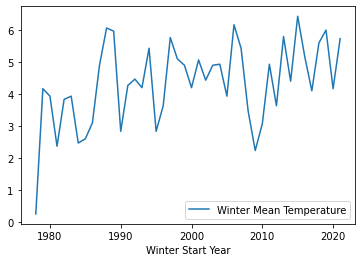

In [18]:
all_winter_means.plot(legend=True)

Unsurprisingly, the data shows that UK Winters are getting warmer (likely as a result of climate change). Let's have a play witht data to see what it shows. Below, I'll look at the data for November and see how well it is correlated to the winter mean temperature.

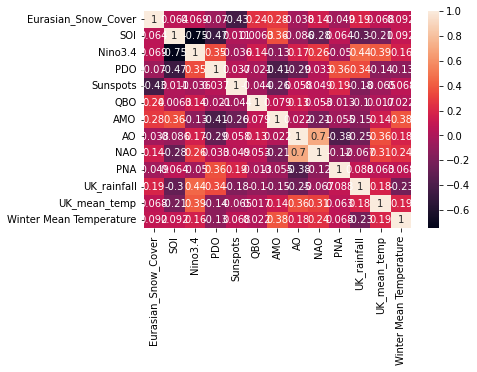

array([[<AxesSubplot:xlabel='Eurasian_Snow_Cover', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='SOI', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='Nino3.4', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='PDO', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='Sunspots', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='QBO', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='AMO', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='AO', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='NAO', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='PNA', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='UK_rainfall', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='UK_mean_temp', ylabel='Eurasian_Snow_Cover'>,
        <AxesSubplot:xlabel='Winter Mean Temperature', ylabel='Eurasian_Snow_Cover'>],
       [<AxesSubplot:xlabel='Eurasian_Snow_Cover', ylabel='SOI'>,
        <AxesS

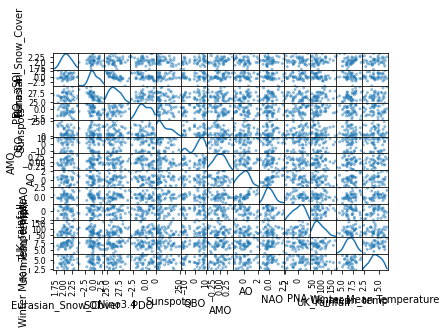

In [19]:
all_months_with_winter_means = pd.merge(features_df,all_winter_means, left_on=features_df.index.year, right_index=True)
all_months_with_winter_means = all_months_with_winter_means.drop(columns=['key_0'])

corr_mat = all_months_with_winter_means[all_months_with_winter_means.index.month==11].corr()
sn.heatmap(corr_mat, annot=True)
plt.show()

pd.plotting.scatter_matrix(all_months_with_winter_means[all_months_with_winter_means.index.month==11], diagonal='kde')

<AxesSubplot:>

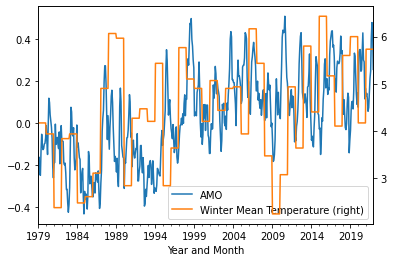

In [20]:
ax = all_months_with_winter_means['AMO'].plot(legend=True)
all_months_with_winter_means['Winter Mean Temperature'].plot(ax=ax, secondary_y=True, legend=True)

Looks like the AMO is the best correlated feature with Winter Mean. The AMO is a measure of log term sea surface temperature in the North Atlantic ocean. A positive correlation indicates that when the AMO cooler in November, this implies the UK may experience a colder winter overall. However, this could be a case of correlation not equaling causation, as the sea surface temperature has been increasing due to climate changes, while UK winters have been getting warmer.
***

## Method 1: Finding Analogues

Now that we have all of the data, we can begin our analysis. 
Firstly, let's try to find analogues to the data we are interested in, i.e. have there been any similar weather patterns seen in the past, and if so, did those years produce cold winters?

We do this by selecting a month that we are interested in, such as September 2022, and calculate the Euclidian Distance of that month to all previous Septembers:

$$ s = \sqrt{\sum_{i=1}^{n} (a_i - b_i)} $$, where n is the number of features </b></b>

If we chose multiple months, we can take the average of the ED for each month we choose. <br /> <br />
For example, let's say we wanted to find the most similar Septembers and Octobers to September/October 2022. 
The function 'find_analogue_years' will return the top n most similar year, and the 'get_temperatures_of_similar_years' will find the mean winter temperature of those years, which we can then compare to the actual mean winter temperature of the selected year.


In [21]:

#######################################################################



def euclidian(arr_a, arr_b):
    return np.sum((arr_a-arr_b)**2)**0.5


def find_analogue_years(search_months, search_year, n_analogues):
    month_mask = [x in search_months for x in features_df.index.month]
    months_to_search_for = features_df[month_mask & (features_df.index.year==search_year)]

    ############# 

    months_to_search = features_df[month_mask]
    
    
    
    years = pd.DataFrame([], columns = ['Similarity'])
    for ind, data in months_to_search.iterrows():
        if ind.year == search_year:
            continue
        
        ed = euclidian(data.values, months_to_search_for.values)
        
        if ind.year in years.index:
            #years.loc[ind.year]=np.mean([years.loc[ind.year].values[0], abs(row[['Nino3.4', 'AMO', 'AO', 'NAO']].values -months_to_search_for[['Nino3.4', 'AMO', 'AO', 'NAO']].values).sum()])
            years.loc[ind.year]=np.nanmean([years.loc[ind.year].values[0], ed])
            
        else:
            #years.loc[ind.year]=abs(row[['Nino3.4', 'AMO', 'AO', 'NAO']].values -months_to_search_for[['Nino3.4', 'AMO', 'AO', 'NAO']].values).sum()
            years.loc[ind.year]=ed
            
            
    most_similar_years = years.nsmallest(n_analogues, 'Similarity')
    return most_similar_years


def get_temperatures_of_similar_years(all_winters, most_similar_years):
    temps = []
    for y in most_similar_years.index:
        temps.append(all_winters.loc[(all_winters['Winter Start Year'] ==y)]['UK_mean_temp'].mean())
    temps = np.array(temps)
    return temps



Prediction: this winter (as compared with the data from 2022) 
will be in the 63.64th percentile of all UK winters in the dataset


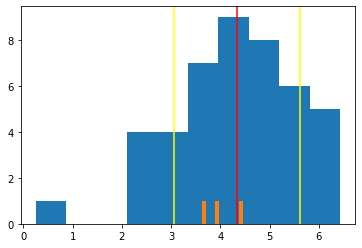

In [22]:
## Finding Analogues

months = [9]

current_year = 2022


most_similar_years = find_analogue_years(months, current_year, 3)

temps = get_temperatures_of_similar_years(all_winters, most_similar_years)

plt.hist(all_winter_means)
plt.axvline(np.mean(all_winter_means), c='red')
plt.axvline(np.mean(all_winter_means)+np.std(all_winter_means), c='yellow')
plt.axvline(np.mean(all_winter_means)-np.std(all_winter_means), c='yellow')
plt.hist(temps)    


percentile = stats.percentileofscore(all_winter_means.values, np.mean(temps))
print("Prediction: this winter (as compared with the data from {date}) \nwill be in the {p}th percentile of all UK winters in the dataset".format(date = current_year, p = round(100-percentile,2)))

As we can see from the histogram generated, most UK winters tend to be between 3°C - 5.5°C. We can also see that for 2022, the average of the most similar years is ~4°C, well within the bounds of a 'normal' UK winter. 

But does this mean anything? Is this prediction method any good?

We now need to test how reliable this method is.So let's see how well the predicted temperatures match the actual temperatures over the entire dataset.

################
Months: [9]
Correlation: 0.2793496919412732
Covariance: 
[[1.29841024 0.28562262]
 [0.28562262 0.80515012]]
r^2:-0.18055949102460334
################
Months: [10]
Correlation: 0.015190011242696783
Covariance: 
[[1.29841024 0.01461886]
 [0.01461886 0.7133441 ]]
r^2:-0.5402535305500853
################
Months: [11]
Correlation: 0.18494080817878106
Covariance: 
[[1.29841024 0.17115971]
 [0.17115971 0.65966839]]
r^2:-0.26662322382673564
################
Months: [9, 10, 11]
Correlation: -0.41827794958057524
Covariance: 
[[ 1.29841024 -0.39901224]
 [-0.39901224  0.70085887]]
r^2:-1.1686624233096858
################
Months: [9, 10]
Correlation: -0.11216236454338616
Covariance: 
[[ 1.29841024 -0.11104651]
 [-0.11104651  0.75492463]]
r^2:-0.7591822258528571
################
Months: [10, 11]
Correlation: -0.13004611296040422
Covariance: 
[[ 1.29841024 -0.11165282]
 [-0.11165282  0.5677181 ]]
r^2:-0.6455817660426573


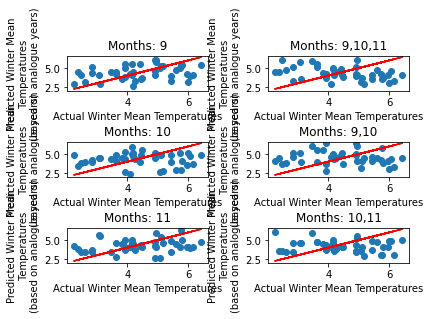

In [128]:

############################################################################
def evaluate_method1(all_winters, months_to_check,axs, subplotx, subploty):
    print("################")
    print("Months: "+str(months_to_check))
    predicted_based_on_analogues = []
    actual_winter_temps = []
    for i in np.arange(min(all_winters.index.year),max(all_winters.index.year),1):

        similar_years = find_analogue_years(months_to_check, i, 2)
        temps = get_temperatures_of_similar_years(all_winters, similar_years)

        predicted_based_on_analogues.append(np.nanmean(temps))
        actual_winter_temps.append(all_winter_means[all_winter_means.index==i].values[0])

    axs[subplotx,subploty].set_title("Months: "+','.join(str(i) for i in months_to_check))
    axs[subplotx,subploty].set_xlabel('Actual Winter Mean Temperatures')
    axs[subplotx,subploty].set_ylabel('Predicted Winter Mean\n Temperatures \n(based on analogue years)')
    axs[subplotx,subploty].plot(np.array(actual_winter_temps), np.array(actual_winter_temps), c='red')
    axs[subplotx,subploty].scatter(np.array(actual_winter_temps), np.array(predicted_based_on_analogues))

    corr, _ = pearsonr(np.array(actual_winter_temps), np.array(predicted_based_on_analogues))
    print("Correlation: "+ str(corr))
    print('Covariance: \n'+ str(np.cov(np.array(actual_winter_temps), np.array(predicted_based_on_analogues))))
    print('r^2:'+ str(r2_score(np.array(actual_winter_temps), np.array(predicted_based_on_analogues))))

    return

fig, axs = plt.subplots(3,2)
fig.tight_layout(pad=3.0)
months_to_check = [9,]
evaluate_method1(all_winters, months_to_check,axs, 0,0)
months_to_check = [10,]
evaluate_method1(all_winters, months_to_check,axs, 1,0)
months_to_check = [11,]
evaluate_method1(all_winters, months_to_check,axs, 2,0)
months_to_check = [9,10,11]
evaluate_method1(all_winters, months_to_check,axs, 0,1)
months_to_check = [9,10]
evaluate_method1(all_winters, months_to_check,axs, 1,1)
months_to_check = [10,11]
evaluate_method1(all_winters, months_to_check,axs, 2,1)

As you would expect, using the data from November produces a better correlation with the Winter Mean Temperature than the October data (although not the case for September (!)). Interestingly, adding more months does not seem to improve the prediction. This could be due to the changable nature of the weather, meaning that it's difficult to find 3 consecutive months that are similar to 3 other consecutive months!

Overall, it doesn't seem that this is a very good way to predict this years Winter Mean temperature, as it seems to be predicting the something very close to the mean Winter Temperature. This is true no matter how many similar years you choose.

***

# Method 2: Machine learning

Let's see if we can use ML to perform a better prediction. First, we need to split the data up into training and test sets. 

In [140]:
#### ML training with single month

def dataframe_to_training_and_test_sets(df, pct_split, months_used_for_prediction, label_col):
    
    autumn = [x in months_used_for_prediction for x in df.index.month]
    df_filtered = df[autumn]
    
    df_train = df_filtered.loc[df_filtered.index[:int(len(df_filtered.index)*pct_split)],:]
    df_test = df_filtered.loc[df_filtered.index[int(len(df_filtered.index)*pct_split):],:]
    

    y_train = df_train[label_col].round(3).values
    X_train = df_train.drop(columns = [label_col]).values

    y_test = df_test[label_col].round(3).values
    X_test = df_test.drop(columns = [label_col]).values
    return X_train,y_train, X_test, y_test, df_train, df_test

label_col = 'Winter Mean Temperature'
all_months_with_winter_means['Month'] = all_months_with_winter_means.index.month
all_months_with_winter_means_shuffled = all_months_with_winter_means.sample(frac=1, random_state=123) # going to shuffle the data so that we have some of the more recent, warmer years in the training set
X_train, y_train, X_test, y_test, df_train, df_test = dataframe_to_training_and_test_sets(all_months_with_winter_means_shuffled, 0.8, [9,10,11], label_col)

Then we need to find a suitable regression model to perform our predictions:

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
              ('LR', LinearRegression()), 
              ('SVR', SVR()),
              ('RFR', RandomForestRegressor()),
              ('GBR', GradientBoostingRegressor()),
                ('XGR', XGBRegressor()),
            ]
    results = []
    names = []
    scoring = ['r2']
    for name, model in models:
            kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(name)
            print("R^2: ",r2_score(y_test, y_pred))
            results.append(cv_results)
            names.append(name)
    return 

run_exps(X_train, y_train, X_test, y_test)


LR
R^2:  0.1603952612925963
SVR
R^2:  -0.007026424218675276
RFR
R^2:  0.39754923181773816
GBR
R^2:  0.4308514206317199
XGR
R^2:  0.319008600725606


It looks like Linear Regression is the model with the best r^2

In [212]:
def naive_confidence_intervals(model, X, y, alpha):
    residuals = y - model.predict(X)
    #plt.hist(residuals) # histogram indicates the errors are not normally distributed, therefore need to use the jackknife method
    ci = np.quantile(residuals, 1 - alpha)
    return ci

def jackknife_confidence_intervals(model, X_train, y_train, X_test, y_test, alpha):
    kf = KFold(n_splits=len(y_train)-1, shuffle=True, random_state=123)
    res = []
    for train_index, test_index in kf.split(X_train):
        X_train_, X_test_ = X_train[train_index], X_train[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]

        model.fit(X_train_, y_train_)
        res.extend(list(y_test_ - model.predict(X_test_)))
    ci = np.quantile(res, 1 - alpha)
    return ci

def train_and_evaluate(model_type, X_train, y_train, X_test, y_test):
    model = model_type
    model.fit(X_train,y_train)
    # define model evaluation method
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    scores = cross_val_score(model, X_train,y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = np.abs(scores)
    print('Mean MAE: %.5f (%.8f)' % (scores.mean(), scores.std()) )

    mae = mean_absolute_error(y_test, model.predict(X_test))
    mape = mean_absolute_percentage_error(y_test, model.predict(X_test))
    
    ci = jackknife_confidence_intervals(model, X_train, y_train, X_test, y_test, 0.2) # CI at the 80th percentile
    #ci = naive_confidence_intervals(model,X_test, y_test, 0.05)
    
    r2 = r2_score(y_test, model.predict(X_test))
    print("r^2 (test set): ", r2)

    
    print("MAE (test set): ",mae)
    return model, ci

def scatter_plot_of_results(y_test, predicted_vals, interval):
    plt.scatter(y_test, predicted_vals, label='Predictions')
    plt.errorbar(y_test, predicted_vals, yerr=interval, fmt='o', label = "CI at 80th pctile")
    plt.plot(y_test, y_test, label='Perfect prediction line', c='r')
    plt.xlabel('Actual ($^\circ$C)')
    plt.ylabel('Predicted ($^\circ$C)')
    plt.title('Actual vs predicted')
    plt.legend()
    return
    

Mean MAE: 1.17752 (0.31619627)
r^2 (test set):  0.6595337373342609
MAE (test set):  1.1167307692307697


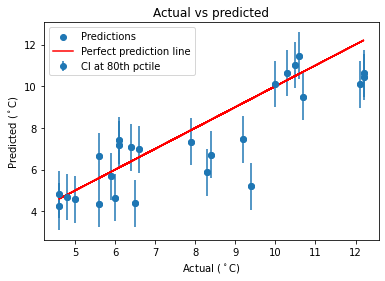

In [213]:
model, interval = train_and_evaluate(RandomForestRegressor(), X_train, y_train, X_test, y_test)
scatter_plot_of_results(y_test, model.predict(X_test), interval)


In [145]:
def get_forecast(percentile):
    forecasts = {0: 'Very Cold', 20: 'Colder than average', 40: 'Around Average', 60: 'Milder than average', 80: 'Very Mild',100: ""}
    keys = list(forecasts.keys())
    predicted_forecast = forecasts[[keys[k] for k in range(len(keys)) if percentile > keys[k] and  percentile < keys[k+1]][0]]
    return predicted_forecast

def winter_prediction(percentile, date):
    print("Prediction: this winter (as predicted with the latest data from {date} \nwill be in the {p}th percentile of all UK winters from the dataset\n".format(date = predicted_from_date, p = round(percentile,2)))

features_df['Month'] = features_df.index.month
predicted_from_date = features_df.index[-1]
predict_this_winter = model.predict(np.array(features_df.loc[predicted_from_date].values).reshape(1,-1))[0]
predict_this_winter

4.83075

In [146]:
percentile = stats.percentileofscore(all_winter_means.values, predict_this_winter)
winter_prediction(percentile, predicted_from_date)
get_forecast(percentile)

Prediction: this winter (as predicted with the latest data from 2022-09-01 00:00:00 
will be in the 56.82th percentile of all UK winters from the dataset



'Around Average'

Overall, this method does much better than the analogue method we used before, although it could be improved. Can we do better than this?

***

# Method 3: ML with a lookback

This method is similar to method 2, however, we are going to add a lookback to the features, i.e. not only taking into account the current months data as a feature, but also previous months.

In [147]:
#### ML training with many months

def dataframe_with_lookback(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(df.columns[j]) for j in range(n_vars)]
        else:
            names += [(df.columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

To give the model the best chance of making a good prediction, let's use the data for November (as the latest data), and lookback 2 months.

In [148]:
df_shifted = dataframe_with_lookback(all_months_with_winter_means, n_in=2, n_out=1, dropnan=True)
df_shifted['Month'] = df_shifted.index.month

df_shifted = df_shifted.drop(columns = [col for col in df_shifted.columns if label_col in col and col != label_col])

df_shifted = df_shifted.sample(frac=1.0, random_state=123)
X_train, y_train, X_test, y_test, df_train, df_test = dataframe_to_training_and_test_sets(df_shifted, 0.8, [9,10,11], label_col)

In [149]:
run_exps(X_train, y_train, X_test, y_test)

LR
R^2:  -0.10098019977034256
SVR
R^2:  -0.21862449182580934
RFR
R^2:  0.1740263054356963
GBR
R^2:  0.35616737999262116
XGR
R^2:  0.1584880354841618


XGBRegressor seems to be the best performer, albeit pretty poor performance

Mean MAE: 0.90292 (0.13446777)
r^2 (test set):  0.18066621573589392
MAE (test set):  0.8392910396869365


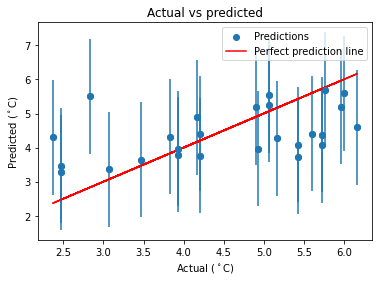

In [150]:
model, interval = train_and_evaluate(XGBRegressor(), X_train, y_train, X_test, y_test)
scatter_plot_of_results(y_test, model.predict(X_test), interval)


In [151]:
predicted_from_date = df_shifted.index[-1]
features = df_shifted.drop(columns=['Winter Mean Temperature']).loc[predicted_from_date]

predict_this_winter = model.predict(features.values.reshape(1,-1))[0]

percentile = stats.percentileofscore(all_winter_means.values, predict_this_winter)
winter_prediction(percentile, predicted_from_date)
get_forecast(percentile)

Prediction: this winter (as predicted with the latest data from 2021-09-01 00:00:00 
will be in the 36.36th percentile of all UK winters from the dataset



'Colder than average'

Hmm, the model does not seemed to have improved with more features. Perhaps there are some redundant features, let's rank the features:


In [152]:
######## Feature Importance Section

# define the method
rfe = RFE(estimator=XGBRegressor(), n_features_to_select=5)
rfe.fit(X_train,y_train)

df_feature_selection = pd.DataFrame([], columns = ['Feature Name', 'Ranking'])
for i in range(X_train.shape[1]):
    #print('Column: %d, Name: %s,  Selected %s, Rank: %.3f' % (i,df_train.drop(columns=['Winter Mean Temperature']).columns[i],  rfe.support_[i], rfe.ranking_[i]))
    df_feature_selection = df_feature_selection.append({'Feature Name': df_train.drop(columns=['Winter Mean Temperature']).columns[i], 'Ranking': rfe.ranking_[i]}, ignore_index=True)

df_feature_selection.sort_values('Ranking')

,Feature Name,Ranking
36,UK_rainfall,1
32,AMO,1
17,Sunspots(t-1),1
15,Nino3.4(t-1),1
14,SOI(t-1),1
35,PNA,2
4,Sunspots(t-2),3
16,PDO(t-1),4
7,AO(t-2),5
30,Sunspots,6


In [153]:
#df_shifted = df_shifted[['UK_rainfall','NAO', 'QBO', 'AO(t-1)', 'AMO','Month', 'Winter Mean Temperature']]
df_shifted = df_shifted[['UK_rainfall','Nino3.4(t-1)', 'Sunspots(t-1)', 'SOI(t-1)', 'AMO','Month', 'Winter Mean Temperature']]
X_train, y_train, X_test, y_test, df_train, df_test = dataframe_to_training_and_test_sets(df_shifted, 0.8, [9,10,11], 'Winter Mean Temperature')

Mean MAE: 0.70440 (0.17346970)
r^2 (test set):  -0.23807772090063328
MAE (test set):  1.1042655073312613


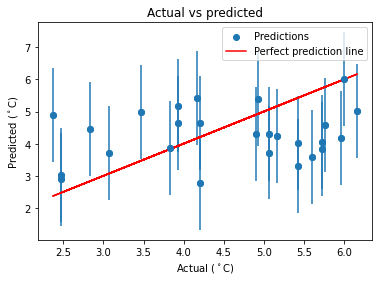

In [154]:
model, interval = train_and_evaluate(XGBRegressor(), X_train, y_train, X_test, y_test)
scatter_plot_of_results(y_test, model.predict(X_test), interval)

It doesn't seem like filtering the features produces any gains. Lesson learned, more features does not alway equal a better model.
Intuitively this makes sense, what matters most when trying to predict weather/climate is the most recent observations, not something that occurs 2 months ago.

***

# Method 4: Using ML to predict next months mean temperature

In [180]:
df_shifted = dataframe_with_lookback(all_months_with_winter_means.drop(columns='Winter Mean Temperature'), n_in=2, n_out=1, dropnan=True)
df_shifted['Month'] = df_shifted.index.month

In [202]:
n_months_ahead = 1

df_shifted['UK_mean_temp (t+1)'] = df_shifted['UK_mean_temp']
df_shifted['UK_mean_temp (t+1)'] = df_shifted.shift(-n_months_ahead)['UK_mean_temp (t+1)']
df_shifted = df_shifted.dropna(axis=0)

In [203]:
X_train, y_train, X_test, y_test, df_train, df_test = dataframe_to_training_and_test_sets(df_shifted, 0.8, [9,10,11], 'UK_mean_temp (t+1)')

In [204]:
run_exps(X_train, y_train, X_test, y_test)

LR
R^2:  0.4640143981370094
SVR
R^2:  0.03044869387272242
RFR
R^2:  0.6697714309544459
GBR
R^2:  0.6785911103425025
XGR
R^2:  0.6448591987840867


Mean MAE: 1.27559 (0.34232159)
r^2 (test set):  0.6194547144969771
MAE (test set):  1.198695004903353


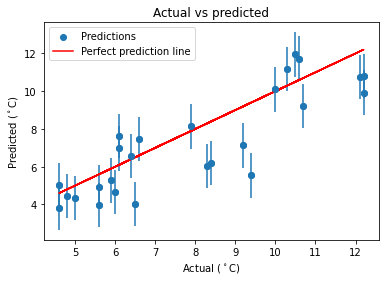

In [205]:
model, interval = train_and_evaluate(XGBRegressor(), X_train, y_train, X_test, y_test)
scatter_plot_of_results(y_test, model.predict(X_test), interval)

In [206]:
df_shifted2 = dataframe_with_lookback(features_df, n_in=2, n_out=1, dropnan=True)
df_shifted2['Month'] = df_shifted2.index.month


In [207]:
predict_using_month = df_shifted2.index[-1] # get last row of dataset (should be the latest data)
predict_next_month = model.predict(df_shifted2[df_shifted2.index == predict_using_month].values.reshape(1,-1))[0]

10.371333 +/- 1.174963150024414
Predicted forecast for month of 2022-10 
Around Average


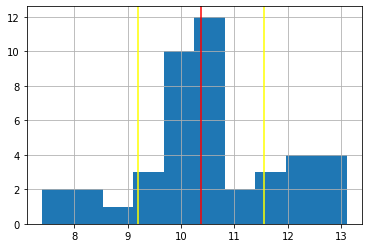

In [209]:
from datetime import timedelta
print(predict_next_month, "+/-", interval)
mean_UK_temps_for_predicted_month = df_shifted2[df_shifted2.index.month ==predict_month.month+n_months_ahead]['UK_mean_temp']
mean_UK_temps_for_predicted_month.hist()
plt.axvline(predict_next_month, c='r')
plt.axvline(predict_next_month+interval, c='yellow')
plt.axvline(predict_next_month-interval, c='yellow')
percentile = stats.percentileofscore(mean_UK_temps_for_predicted_month, predict_next_month)


print("Predicted forecast for month of {date} \n{fc}".format(date = str((predict_using_month+timedelta(days=31*n_months_ahead)).date())[:-3], fc= get_forecast(percentile)))

***
Unsurprisingly, predicting the weather is difficult! Although, we can still draw some conclusions from this analysis.
1. Using climate index analogues is not a good way of predicting
2. Adding data from n months ago does not improve model performance
3. It's much easier to predict next months mean temperature than the average of the next 3 months
4. It's very difficult to say with any confidence what the UK winter of 2022/2023 is going to be like, we'll have to wait and see